In [2]:
import os
import sys
import numpy as np 
import matplotlib.pyplot as plt
import tqdm


# **Ex 0. Getting Started: Cyclic Hopfield model**

<span style="color: blue;">

## **0.1**

In [3]:
def generate_patterns(P,N): 
    """
    Generates P random flatt patterns of size N 
    Args:
        P (int): Number of patterns
        N (int): Size of each pattern
    """
    return np.random.choice([-1,1], size =(P, N))

<span style="color: blue;">

## **0.2**

Given the following equation, 
- Neural state \($S$\):
$$
S_{i}^{(n)}
\;=\;
\tanh\Bigl(\beta \sum_{j=1}^N w_{ij}\,S_{j}^{(n-1)}\Bigr)
\quad (1)
$$

- Connectivity matrix \($W$\) defined by :
$$
w_{ij}
\;=\;
\frac{1}{N}
\Bigl[
  p_{i}^1\,p_{j}^P
  \;+\;
  \sum_{\mu=2}^P
    p_{i}^{\mu}\,p_{j}^{\mu-1}
\Bigr]
\quad (2)
$$

- Overlap (pattern–current state),
$$
m_{(n)}^\mu
\;=\;
\frac{1}{N}
\sum_{i=1}^N
p_i^\mu \, S_i^{(n)}
\quad (3)
$$

We can first rewrite $(1)$ using $(2)$, we obtain,
$$
\begin{aligned}
S_i^{(n+1)}
&=
\tanh\Bigl[
  \beta
  \Bigl(
    \frac{1}{N}
    \sum_{j=1}^N
      \Bigl(
        p_i^1\,p_j^P
        \;+\;
        \sum_{\mu=2}^P
          p_i^\mu\,p_j^{\mu-1}
      \Bigr)\,
      S_j^{(n)}
  \Bigr)
\Bigr].
\end{aligned}
$$

Now, using $(3)$ we can simplify the sum over $j$ and we get,
$$
\begin{aligned}
S_i^{(n+1)}
&=
\tanh\Bigl[
  \beta
  \Bigl(
    p_i^1\,m_{(n)}^P
    \;+\;
    \sum_{\mu=2}^P
      p_i^\mu\,m_{(n)}^{\mu-1}
  \Bigr)
\Bigr].
\end{aligned}
$$

With, 
$$  
\Bigl(
    p_i^1\,m_{(n)}^P
    \;+\;
    \sum_{\mu=2}^P
      p_i^\mu\,m_{(n)}^{\mu-1}
  \Bigr) = \sum_{\mu=1}^P p_i^\mu\,m_{(n)}^{\mu-1} \text{, with } p^{P+1} = p^{1}

$$

<span style="color: blue;">

## **0.3**

We assume :
- A large $\beta$ so that $\tanh(\beta\,x) \approx \mathrm{sign}(x)$.  
- Only orthogonal patterns so $\sum_{i=1}^N p_i^\mu\,p_i^\nu = 0$ when $\mu\neq\nu$.  


First let's compute the overlap variable at $n = 0$ assumin $S_i^{(0)}= p_i^1$,

$$
   m^\mu_{(0)} 
   \;=\; \frac{1}{N}\,\sum_{i=1}^N p_i^\mu\,S_i^{(0)} 
   \;=\; \frac{1}{N}\,\sum_{i=1}^N p_i^\mu\,p_i^1.
$$
  
By orthogonality, this sum is $1$ if $\mu=1$, and $0$ otherwise. Thus $m^1_{(0)} = 1$ and $m^\mu_{(0)}=0$ for $\mu=2,\ldots,P$.

We can now compute the first state, $n = 1$,

From the derived update rule,
$$
S_i^{(1)} 
\;=\; 
\tanh\!\Bigl[
  \beta\,\Bigl(p_i^1\,m^P_{(0)} \;+\;\sum_{\mu=2}^P p_i^\mu\,m^{\mu-1}_{(0)}\Bigr)
\Bigr].
$$

We can see that because $m^\mu_{(0)}=1$ for $\mu = 1$ and $0$ otherwise, the only nonzero term in the sum is when $\mu=2$ ($m^{2-1}_{(0)} = m^1_{(0)}=1)$.  
Thus we get $\tanh(\beta\,p_i^2)$. With the asumption of a large $\beta$, $\tanh(\beta\,p_i^2) \approx \mathrm{sign}(p_i^2) = p_i^2$. The first state is thus given by
$$
S_i^{(1)} = p_i^{2}
$$

Now we can see that the same logic repeats :
1) At time $n=1$, the state is $p^2$.  
2) Therfore $m^\mu_{(1)}=1$ if $\mu = 2$ and $0$ otherwise. 
3) Computing the update rule we get $S^{(2)} = p^3$.  
4) Iterating further will thus form a cyclic sequence : 
$$
p^1
\;\to\;
p^2
\;\to\;
\cdots
\;\to\;
p^P
\;\to\;
p^1
\;\to\;
\cdots
$$


<br />
<br />
<br />
<br />

**Remark :**
One can also verify that in the transition of $p^P \;\to\; p^1$, namely the computation of $S^{(1)}$ from $S^{(P)}$ :

The sum $\sum_{\mu=2}^Pp_i^\mu\,m_{(P)}^{\mu-1} = 0$ because

$$
m^\mu_{(P)}  =
\begin{dcases}
    1, & \mu = P \\
    0, & otherwise
\end{dcases}
$$

And since in this case $m_{(P)}^{P} = 1$ ; the other term becomes $p_i^1\,m^P_{(P)} = p_i^1$. From this we can infer that :
$$
S_i^{(P+1)} 
\;=\; 
\tanh\!\Bigl[
  \beta\,\Bigl(p_i^1\,m^P_{(P)} \;+\;\sum_{\mu=2}^P p_i^\mu\,m^{\mu-1}_{(P)}\Bigr)
\Bigr]
\;\approx\; 
\mathrm{sign}(p_i^1)
\;=\; 
p_i^1
$$
Which confirms our cycle analysis.


<span style="color: blue;">

## **0.4**


In [4]:


def compute_overlaps_sim(patterns, S): 
    """"
    Computes the overlaps between patterns P and state S
    Args:
        patterns (numpy.ndarray): Patterns of size (P, N)
        S (numpy.ndarray): State of size (N,)
    """
    N = patterns.shape[1]
    m = np.dot(patterns,S) / N
    return m #(P,) #? mettre les dimensions de l'output dans les docstrings ? 
#! Ici le dot compute une liste de produits scalaires hein ? -> la nommer 'ms' ? 

def compute_state_S(m,patterns, beta): 
    """
    Computes the state S
    Args:
        patterns (numpy.ndarray): Patterns of size (P, N)
        S (numpy.ndarray): State of size (N,)
        beta (float): Scalar parameter
    """
    m_minus_1 = np.roll(m, 1)
    S_update = np.tanh(beta * np.dot(m_minus_1, patterns)) 
    return S_update #(N,)

def simulation(P = 10, N = 100, beta = 4, n_max = None, plot= True, control_cycle = True, verbose = True, fig_nb= 0):
    """
    Simulates the evolution of the state S and the overlaps m
    Args:
        P (int, optional): Number of patterns
        N (int, optional): Number of neurons
        beta (int, optional): Scalar parameter
        n_max (int, optional): Number of iterations
        plot (bool, optional): Whether to plot the overlaps evolution
        control_cycle (bool, optional): Whether to control the cycle of overlaps and early stop the simulation
    """
    if n_max is None :
        n_max = 2* P
    m_track = []
    patterns = generate_patterns(P, N) 
    S= patterns[0,:].copy().astype(float) #initial state is the first pattern
    S_track = [S.copy()]
    previous_m = None
    for n,i in enumerate(range(n_max)): 
        m = compute_overlaps_sim(patterns, S)
        S = compute_state_S(m, patterns, beta) #compute_state_S(m, patterns, S, beta)
        S_track.append(S.copy())
        m_track.append(m)
        
        # ------- CYCLE CONTROL IMPLEMENTATION --------
        if control_cycle :
            max_overlap = np.argmax(m)
            if n == 0 : 
                previous_m = max_overlap
                continue
            else :
                if previous_m == P-1 : 
                    if max_overlap == 0 or max_overlap == P-1 : 
                        previous_m = max_overlap
                        if n == n_max - 1 : 
                            retreived = True
                            if verbose : 
                                print("Simulation finished | Cycle retreived")
                        continue
                    else : 
                        previous_m = max_overlap
                        retreived = False     
                        if verbose :                    
                            print("1 Early stopping itt: {} | Cycle not retreived in correct order {} -> {}".format(n,previous_m, max_overlap))
                        break
                if max_overlap == previous_m or max_overlap == previous_m + 1 : 
                    previous_m = max_overlap
                    if n == n_max - 1 : 
                        retreived = True
                        if verbose : 
                            print("Simulation finished | Cycle retreived")
                    continue
                else : 
                    retreived = False
                    if verbose : 
                        print("2 Early stopping itt: {} | Cycle not retreived in correct order {} -> {}".format(n,previous_m, max_overlap))
                    previous_m = max_overlap
                    break
        

    m_track = np.array(m_track)
    S_track = np.array(S_track)
    if plot : 
        plt.figure(figsize=(10, 5))
        for mu in range(P):
            plt.plot(m_track[:, mu], label=f'Pattern_{mu + 1}')
        if fig_nb != 0 :
            plt.title(f'Figure {fig_nb}. Overlaps Evolution')
        else :
            plt.title('Overlaps Evolution')
        plt.xlabel('Iteration')
        plt.ylabel('Overlap')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=5, fancybox=True,)
        # plt.tight_layout()
        plt.show()
    if control_cycle : 
        return  patterns, S_track, m_track, retreived
    else:   
        return  patterns, S_track, m_track

Simulation finished | Cycle retreived


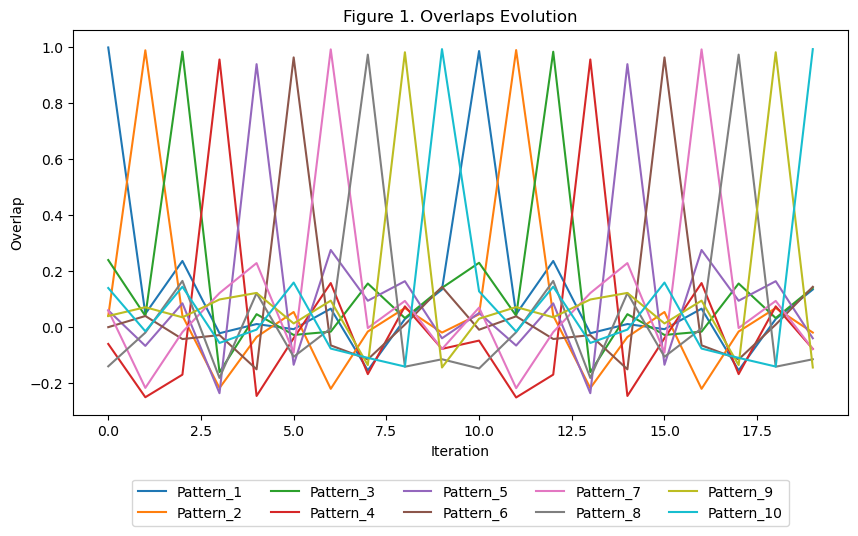

In [4]:

#! Call corresponding to the point 0.4

sim_P10 = simulation(verbose = True, fig_nb=1)

<span style="color: blue;">

## **0.4**

Figure 1 shows the simulation of the evolution of the overlap $m^\mu$ for each of $P = 10$ randomly generated patterns in a cyclic Hopfield model with $N = 100$ neurons and $\beta = 4$, over 20 iterations. From this plot, we observe the expected cyclic retrieval property of the model:

- At iteration $n$, one pattern $p^\mu$ has an overlap close to 1 (indicating that the network’s state closely matches that pattern), while the overlaps with all other patterns remain near zero.
- At the next iteration $n+1$, the network switches to a different pattern $p^{\mu+1}$, which now exhibits an overlap near 1.
- This behavior repeats for each of the stored patterns in turn, confirming that the network sequentially cycles through the stored patterns rather than converging to a single fixed point as the classical hopfield model would.

Thus these results align with the expected behavior of a cyclic Hopfield network, where the system follows a limit cycle—cycling through each pattern


# **Ex 1. Sequence storage and retrieval**

<span style="color: blue;">

## **1.1**

Figure 2 shows the same cyclic Hopfield simulation setup but with $P = 50$ patterns instead of $P = 10$. We observe that the retrieval cycle fails to occur, and the simulation stops early at iteration 5 because no sequential pattern recovery occurs. Also we can see that the peak overlap values at each itteration are noticeably smaller compared to the $P = 10$ case, indicating weaker alignment between the network state and any individual pattern.

This is likely due to the crosstalk from many pattern, with $P = 50$ for only $N = 100$ neurons, the effective capacity of the network is exceeded. The interference, similarity among these patterns (“crosstalk”) prevents clear transitions from one pattern to the next.


As a result, the network exhibits more diffuse behavior, illustrating that the cycle retrieval mechanism breaks down when $P$ is too large relative to $N$.


2 Early stopping itt: 8 | Cycle not retreived in correct order 7 -> 11


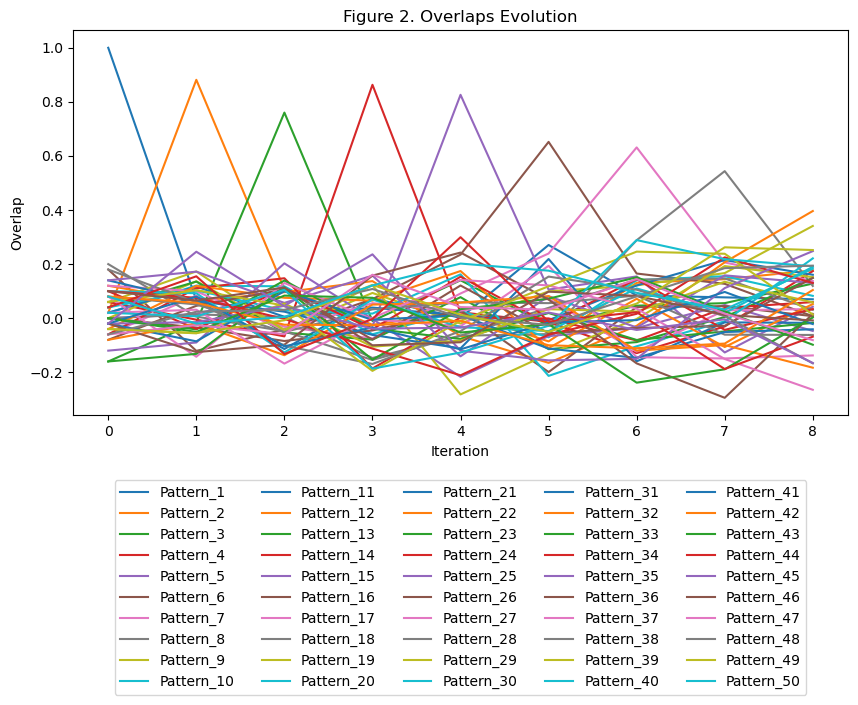

In [5]:
# Cycle retrieving control implemented directly in sumulation function allowing early stop
#sim_P10 = simulation(verbose = True)
sim_P50 = simulation(P = 50, verbose = True, fig_nb = 2)

<span style="color: blue;">

## **1.2**

In [5]:

#! Stochasicity in the results only in the initialization of the patterns ?
#* What about the beginning of the computation of the overlap ( not the beginning of the cercle ? -> with the current implementation, beginning not verified ?)
def get_frac_retrieved_cycles_vs_alpha(N,eval_per_a=10,alphas=np.arange(0.05, 0.45, 0.01),verbose=False):


    retrieved_frac = {}
    for a in tqdm.tqdm(alphas, desc=f"Alphas (N={N})"):
        correct_cycle = 0
        for _ in range(eval_per_a):
            P = int(N * a)
            _, _, _, retrieved = simulation(
                P=P, N=N, beta=4, n_max=2*P,
                plot=False, control_cycle=True, verbose=verbose
            )
            if retrieved:
                correct_cycle += 1
        retrieved_frac[a] = correct_cycle / eval_per_a

    x = sorted(retrieved_frac.keys())
    y = [retrieved_frac[k] for k in x]
    return x, y


In [ ]:

x_100, y_100 = get_frac_retrieved_cycles_vs_alpha(N=100)
x_1000, y_1000 = get_frac_retrieved_cycles_vs_alpha(N=1000)

plt.figure(figsize=(10, 5))
plt.plot(x_100,  y_100,  marker='o', label='N=100')
plt.plot(x_1000, y_1000, marker='o', label='N=1000')
plt.title('Figure 3. Fraction of Correct Cycles vs Alpha (P/N)')
plt.xlabel('Alpha')
plt.ylabel('Fraction of Correct Cycles')
plt.legend()
plt.show()

<span style="color: blue;">

## **1.3 - 1.4**

Figure 3 show the fraction of correctly retrieved cycles as a function of the load $\alpha = \tfrac{P}{N}$ for two network sizes, $N=100$ and $N=1000$. We say a cycle is correctly retrieved if the network manages to recovers all $P$ patterns in the proper order.

From the plot, we can define the cycle capacity which correspond roughly to the largest $\alpha$ at which correct retrieval is still high. For $N=100$, the transition from near‐perfect retrieval to low retrieval occurs around $\alpha \approx 0.20\!-\!0.25$. For $N=1000$, the transition is much sharper and also centered at $\alpha \approx 0.25$. Passed these values the models fail to recover the cycle as the interference, crosstalk between patterns are to high for the networks's capacities.

Hence, the cycle capacity appears to lie around $\alpha \approx 0.20\!-\!0.25$ in these simulations, with the exact threshold depending on the network size and the randomness of the patterns.

The larger network ($N=1000$) shows a more abrupt drop in retrieval fraction. This can likely be attributed to the reduced Finite-size effects due to the larger model size. So once the network surpasses its capacity, retrieval fails almost completely.



<span style="color:blue">

### **1.5 Bonus**

Let the total number of patterns be $P$. We assume $P$ is even, so each cycle has length $P/2$. Thus, we define:

- **Cycle 1**: $\{x^1, x^2, \dots, x^{P/2}\}$ with the wraparound condition $x^{P/2 + 1} = x^1$.  
- **Cycle 2**: $\{y^1, y^2, \dots, y^{P/2}\}$ with the wraparound condition $y^{P/2 + 1} = y^1$.  

Here, each $\{x^\mu\}$ and $\{y^\nu\}$ is a distinct and random set of $\pm1$ neuron states of length $N$. We want the network to retrieve only the corresponding cycle based on its initialization, so : 

- If $S^{(0)}$ is initialized as $x^1$, the model should follow the sequence $x^1 \to x^2 \to \dots \to x^{P/2} \to x^1 \dots$.
- If $S^{(0)}$ is initialized as $y^1$, the model should follow the sequence $y^1 \to y^2 \to \dots \to y^{P/2} \to y^1 \dots$.


Because the two cycles are randomly generated, we can treat the patterns as distinct and therefore assume that the cross‐terms from one cycle will be nearly orthogonal (or cancel out) with respect to the other cycle. This assumption holds only when the number of neurons $N$ is sufficiently large relative to the total number of patterns $P$. When $N \gg P$, random $\pm1$ patterns tend to be nearly orthogonal, so the interference (or crosstalk) between the cycles remains minimal. In this regime, we can build the combined weight matrix simply by summing the connectivity matrices for each individual cycle:

$$
w_{ij} 
\;=\; 
\frac{1}{N}
\Biggl(
\underbrace{\sum_{\mu=1}^{P/2} x^\mu_i \, x^{\mu+1}_j}_{\text{Cycle 1}} 
\;+\;
\underbrace{\sum_{\nu=1}^{P/2} y^\nu_i \, y^{\nu+1}_j}_{\text{Cycle 2}}
\Biggr).
$$

This orthogonality prevents the network from jumping from an $x$‐pattern to a $y$‐pattern, assuming there is little overlap between $\{x^\mu\}$ and $\{y^\nu\}$. Hence, multiple disjoint cycles can be stored in the same network by simply adding them together.

We can then use the same Hopfield‐style update rule introduced earlier:

$$
s_i^{(t+1)} 
\;=\; 
\tanh\!\Bigl[
  \beta \sum_{j=1}^N w_{ij}\,s_j^{(t)}
\Bigr].
$$

And we expect that,

- If $s^{(0)}$ is close to an $x^\mu$ pattern, the network’s dynamics traverse the full $x$‐cycle.
- Conversely, if $s^{(0)}$ is near one of the $y^\nu$ patterns, the model follows the $y$‐cycle.

Figure 4 shows a simulation of this scenario with $P=20$ total patterns: 10 patterns for cycle $x$ and 10 for cycle $y$, all for a network of $N=100$ neurons. The first plot depicts the dynamics (overlaps vs. iteration) when $S^{(0)}$ is initialized as $x^1$, and the second plot when $S^{(0)}$ is initialized as $y^1$. We see that, as expected, the model successfully recovers the respective cycle in each case in the provided $P$ and $N$ conditions that are such that cross‐talk within and between cycles remains sufficiently small.

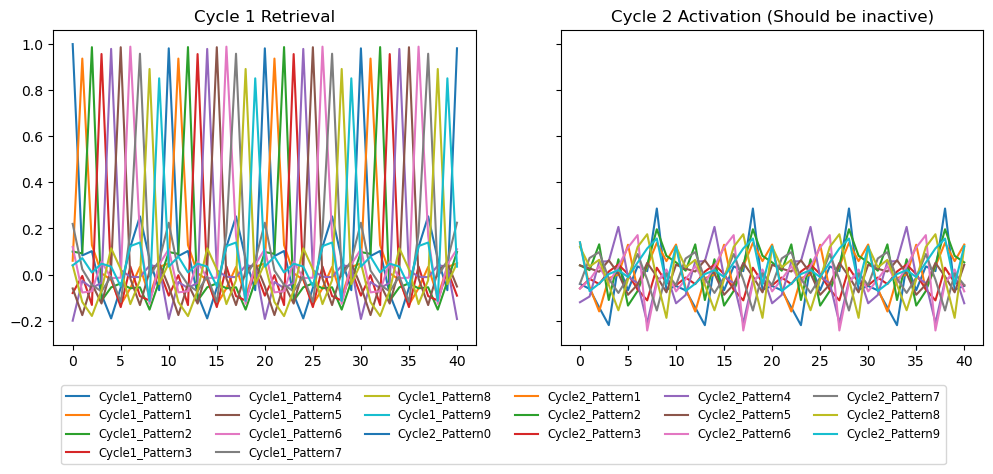

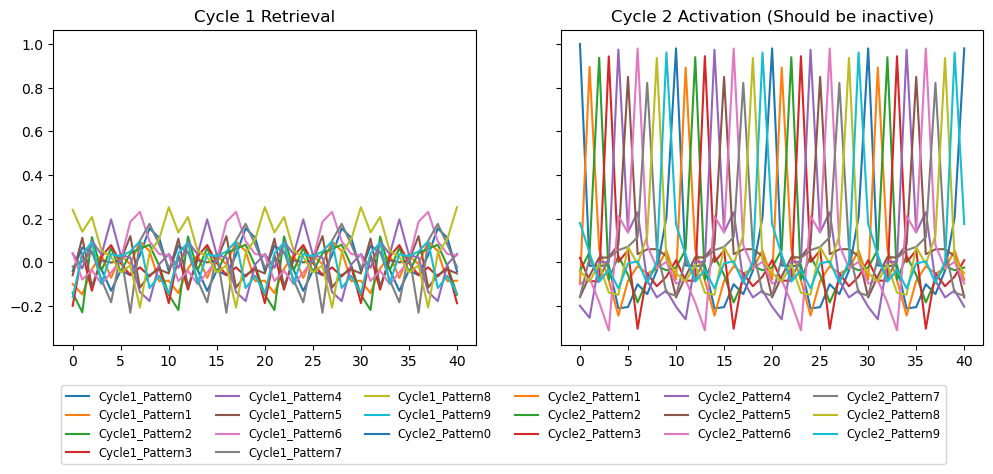

In [6]:
def generate_two_patterns_cycle(P_half, N):
    cycle1 = np.random.choice([-1, 1], size=(P_half, N))
    cycle2 = np.random.choice([-1, 1], size=(P_half, N))
    return cycle1, cycle2

def build_W_from_one_cycle_patterns(patterns):
    P, N = patterns.shape
    W = np.zeros((N, N))
    for mu in range(P):
        prev = (mu - 1) % P
        W += np.outer(patterns[mu], patterns[prev])
    return W / N

cycle1, cycle2 = generate_two_patterns_cycle(10, 100)
W1 = build_W_from_one_cycle_patterns(cycle1)
W2 = build_W_from_one_cycle_patterns(cycle2)
W_total = W1 + W2 

def S_update(W, S0, beta, n_max):
    S = S0.copy()
    S_track = [S.copy()]
    for i in range(n_max):
        S = np.tanh(beta * np.dot(W,S))
        S_track.append(S.copy())
    return np.array(S_track)


def compute_overlaps(S_track, patterns):
    return np.dot(S_track, patterns.T) / patterns.shape[1]  

S1_0 = cycle1[0].copy()
S1 = S_update(W_total, S1_0, beta=4, n_max=40)
m1 = compute_overlaps(S1, cycle1)
m2 = compute_overlaps(S1, cycle2) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax1.set_title("Cycle 1 Retrieval")
lines1 = [ax1.plot(m1[:, i], label=f"Cycle1_Pattern{i}") for i in range(m1.shape[1])]

ax2.set_title("Cycle 2 Activation (Should be inactive)")
lines2 = [ax2.plot(m2[:, i], label=f"Cycle2_Pattern{i}") for i in range(m2.shape[1])]


handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2,
           loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=6, fontsize='small')

plt.subplots_adjust(bottom=0.25)

plt.show()


S1_0 = cycle2[0].copy()
S1 = S_update(W_total, S1_0, beta=4, n_max=40)
m1 = compute_overlaps(S1, cycle1)
m2 = compute_overlaps(S1, cycle2) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax1.set_title("Cycle 1 Retrieval")
lines1 = [ax1.plot(m1[:, i], label=f"Cycle1_Pattern{i}") for i in range(m1.shape[1])]

ax2.set_title("Cycle 2 Activation (Should be inactive)")
lines2 = [ax2.plot(m2[:, i], label=f"Cycle2_Pattern{i}") for i in range(m2.shape[1])]


handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2,
           loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=6, fontsize='small')

plt.subplots_adjust(bottom=0.25)

plt.show()



# **Ex 2. Continuous dynamical system**

<span style="color:blue">

### **2.1**

In [7]:
def simulation_continuous(P = 10, N = 100, beta = 4.0, plot = True, tau = 5.0, tau_delay= 0.5, dt = 0.5, T = 100.0, control_cycle = True, verbose = False, exp = None):
    
    """
    Simulates the continuous evolution of the neurons X and the overlaps M using Forward Eurler integration
    
    Args:
        P (int, optional): Number of patterns
        N (int, optional): Number of neurons
        beta (int, optional): Scalar parameter
        plot (bool, optional): Whether to plot the overlaps evolution
        tau (double): Time constant of the ODE
        tau_delay (double): Interaction delay between neurons
        dt (double): Spacing of time points at which the network is evaluated
        T (double): Duration of the evaluation
        control_cycle (bool, optional): Whether to control the cycle of overlaps and early stop the simulation

    Returns:
        patterns (P, N)  
        X (n_steps+1, N): Neuron states over time
        M (n_steps+1, P): Overlaps over time
    """
    
    patterns = generate_patterns(P, N)
    n_steps = int(np.ceil(T/dt))
    delay_step = int(round(tau_delay / dt))
    #print("nb steps : ", n_steps)

    #? Store the history
    X = np.zeros((n_steps + 1, N))
    M = np.zeros((n_steps + 1, P))

    #? Initialization

    #* In the case of the 2.4 experiment, the appropriate number of patterns are concatenanted at initialization
    if not (exp == None):
        experiment, nb_init = exp 
        init_pattern = patterns[0].astype(float)
        for n in range(nb_init-1):
            init_pattern += patterns[n+1]
        
        X[0] = np.sign(init_pattern)
    else :
        X[0] = patterns[0].astype(float) #!+ 0.05 * np.random.randn(N) #!Added randomness to give the system a little kick to start cycling?
        
    M[0] = compute_overlaps_sim(patterns, X[0])

    #*State variables
    current_m     = None           #? last accepted pattern index
    cand_m        = None           #? candidate pattern we just jumped to
    peak_value    = -np.inf        #? running max of overlap[cand_m]
    peak_counter  = 0              #? how long we've watched cand_m
    retrieved     = False
    m_thresh = 0.5
    wait_steps = int(tau_delay/dt) #! No theory yet to back at how much to put it 

    for k in range(n_steps):
        
        #? Assumption : state of the neurons constant before simulation
        if k - delay_step < 0:
            x_delay = X[0]
        else:
            x_delay = X[k - delay_step]

        #? Same computation as for the discrete paradigm
        m_delay = compute_overlaps_sim(patterns, x_delay)
        f_delay = compute_state_S(m_delay, patterns, beta)

        #? Implementation of the Fowrard Euler method 
        X[k + 1] = X[k] + (dt / tau) * (-X[k] + f_delay)

        #? Compute overlap at the new time-step ?
        M[k + 1] = compute_overlaps_sim(patterns, X[k + 1])
        #M[k - delay_step] = m_delay

        new_max   = np.argmax(m_delay)


        #! The control cycle is based on the iterations of the patterns in the correct order and on the amplitude > threshold

        if control_cycle :
            #? first Euler step: just initialise current_m
            if k == 0:
                current_m = new_max
                continue

            #! Case 1) we are waiting for the peak of cand_m
            if cand_m is not None:

                #? Update current peak value
                if m_delay[cand_m] > peak_value:
                    peak_value = m_delay[cand_m]

                peak_counter += 1

                #? Changed peak or waited enough
                left_cand = new_max != cand_m
                timed_out = peak_counter >= wait_steps

                if left_cand or timed_out:
                    # decide whether to accept the jump
                    good_index = cand_m == (current_m + 1) % P
                    if good_index and peak_value >= m_thresh: #! test without amplitude threshold
                        current_m  = cand_m          # transition accepted
                        cand_m     = None
                        peak_value = -np.inf
                        peak_counter = 0

                        if current_m == 0:           # cycle completed
                            if verbose :
                                print("Early stopping | Cycle retreived")
                            retrieved = True
                            break
                    else:
                        retrieved = False            # wrong index or peak too weak
                        if verbose :
                            if not good_index :
                                print("1 Early stopping itt: {} | Cycle not retreived in correct order {} -> {}".format(k,cand_m, (current_m + 1) % P))
                            elif peak_value < m_thresh : #! test without amplitude threshold
                                #! This criterion is based on the fact that the pattern must dominates the crosstalk noise coming from the other stored patterns
                                print("2 Early stopping itt: {} | Peak is too weak ; at {}".format(k,peak_value))
                        break
                # continue Euler loop
                continue

        #! Case 2) there is no candidate, we check for a new one 
        if new_max != current_m:
            cand_m       = new_max              # start watching new pattern
            peak_value   = m_delay[cand_m]
            peak_counter = 0
            continue

    if plot : 
        plt.figure(figsize=(10, 5))
        for mu in range(P):
            plt.plot(M[:, mu], label=f'Pattern_{mu + 1}')
        #if fig_nb != 0 :
        #    plt.title(f'Figure {fig_nb}. Overlaps Evolution')
        
        plt.title('Overlaps Evolution')
        plt.xlabel('Time step')
        plt.ylabel('Overlap')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=5, fancybox=True,)
        # plt.tight_layout()
        plt.show()

    if control_cycle : 
        return  patterns, X, M, retrieved
    else:   
        return  patterns, X, M


2 Early stopping itt: 300 | Peak is too weak ; at 0.4256994662856154


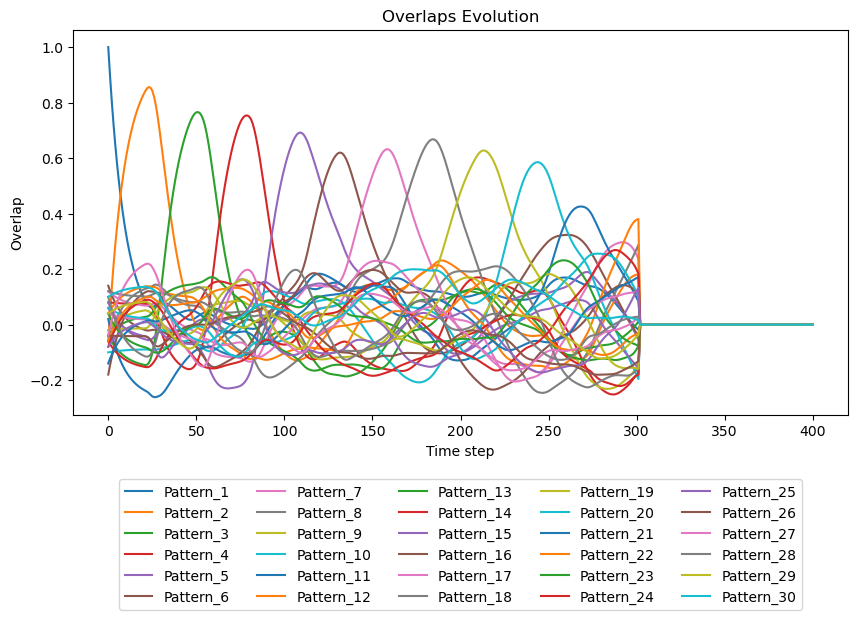

In [8]:

#* vrai ligne 
#*pats, X, M, retr = simulation_continuous(tau_delay = 0.5, control_cycle=True, verbose= True)

#Essai avec gros P
pats, X, M, retr = simulation_continuous(tau_delay = 10.0, control_cycle=True, verbose= True, N=100, P=30, T=200)


#! Why sometimes from ~100 ms, the overlaps are constant, and other times it continues to oscillate?
#?-> When tends to be constant ; the cycle can be retrieved, otherwise, more often than not [could be the tweaking of the criteria at fault...]

<span style="color:blue">

We observe that the overlap oscillate (in the right order), but fail to exceed 0.5, or in some case, stay close to constant after a while : -> Stable focus != limit cycle ?

<span style="color:blue">

### **2.2**

Early stopping | Cycle retreived


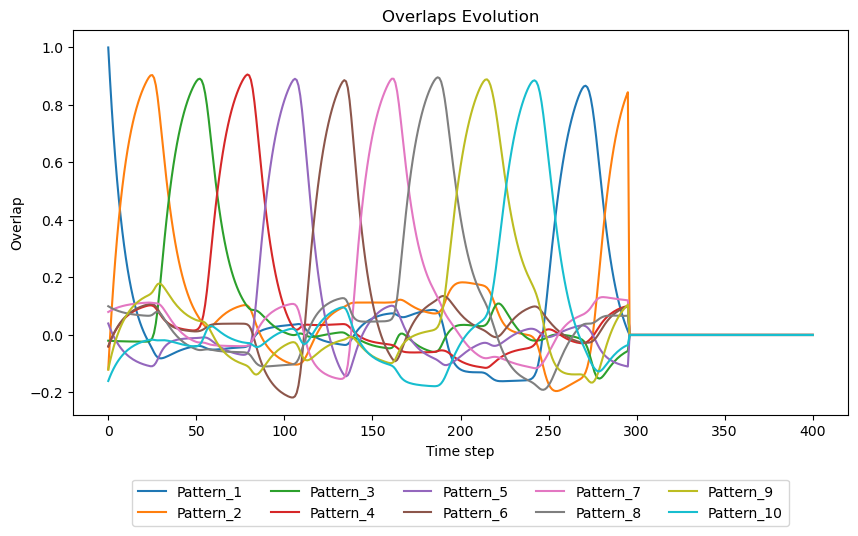

True

In [221]:


#! Si control est true, bloque en passant du 1 au deux (dis qu'il bloque du 9 au 10)
#? Should provide different early stopping criteria!
pats, X, M, retr =  simulation_continuous(tau_delay = 10.0, control_cycle=True, verbose= True, T=200)
retr

<span style="color:blue">

If there is (little to) no delay, as soon as the system wants to start moving to the pattern $\mu + 1$, the feedback of pattern $\mu$ is still strong ($-x_{i}(t)$ term). However, if you introduce some delay, the system will be able to move toward the next pattern without opposition for a little while, before the pull (negative feedback) of the old patterns arrives.  

<span style="color:blue">

### **2.3**

Alphas (N=1000): 100%|██████████| 40/40 [02:08<00:00,  3.22s/it]


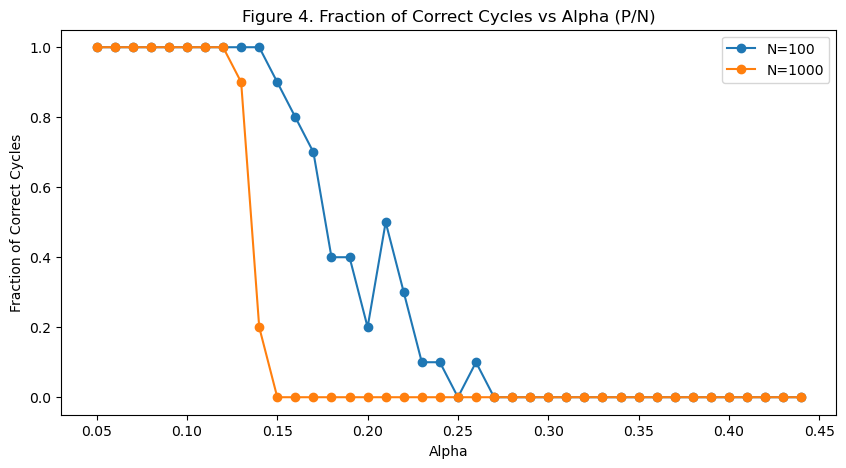

In [ ]:
def get_frac_retrieved_cycles_vs_alpha_continuous(N,eval_per_a=10,alphas=np.arange(0.05, 0.45, 0.01),verbose=False):


    retrieved_frac = {}
    for a in tqdm.tqdm(alphas, desc=f"Alphas (N={N})"):
        correct_cycle = 0
        for _ in range(eval_per_a):
            P = int(N * a)

            #? 10 being tau_delay
            T = 2 * P * 10.0 #T= 2*P #! TYPO DANS L'ENONCE ?
            _, _, _, retrieved = simulation_continuous(
                P=P, 
                N=N, 
                beta=4, 
                plot=False, 
                control_cycle=True, 
                verbose=verbose, 
                T=T, 
                tau_delay = 10.0)
            if retrieved:
                correct_cycle += 1
        retrieved_frac[a] = correct_cycle / eval_per_a

    x = sorted(retrieved_frac.keys())
    y = [retrieved_frac[k] for k in x]
    return x, y


x_100, y_100 = get_frac_retrieved_cycles_vs_alpha_continuous(N=100)
x_1000, y_1000 = get_frac_retrieved_cycles_vs_alpha_continuous(N=1000)

plt.figure(figsize=(10, 5))
plt.plot(x_100,  y_100,  marker='o', label='N=100')
plt.plot(x_1000, y_1000, marker='o', label='N=1000')
plt.title('Figure 4. Fraction of Correct Cycles vs Alpha (P/N)')
plt.xlabel('Alpha')
plt.ylabel('Fraction of Correct Cycles')
plt.legend()
plt.show()

<span style="color:red">
Remarks ;

- La distance entre les courbes N = 100 et N = 1000 peut être comblées en augmentant le threshold d'amplitude. Mais cela bouge les deux courbes significativement en arrière, autour de $\alpha \approx 0.1$.
- Is the convergence criterion according to which the convergence is achieved ('correct behaviour') is that the network cycles between all patterns in the correct order sufficient ? Some simulations show that sometimes the amplitude of the overlaps go down in time. 
- Is the implementation correct if the chosen pattern is not the first one ? Seems so because the patterns are randomly generated, but the implementatation of the criterion is not compatible with this.


<span style="color:blue">

Here again, we see a sharp decline in the larger ($N =1000$) network, although a bit earlier, around $\alpha \approx 0.13-0.15$. For the smaller network

<span style="color:blue">

### **2.4 (Bonus)**

<span style="color:blue">

One activation : the network peaks at one of the pattern ?

- We probably can't use the energy landscape of the network because the update is asynchronous for the cyclic paradigm.

For the cyclic networks, attractors are *limit cycles*, not *fixed points*. We can have unusual limit cycles trajectories that cycle through patterns in the *wrong* order or with a strange period. These are real attractors : dynamic orbits but are not the constant $m^{\mu}(t)$ with no oscillations, no drift, that would consitute the equivalent of the fixed point in the standard *static* Hopfield Network.



1


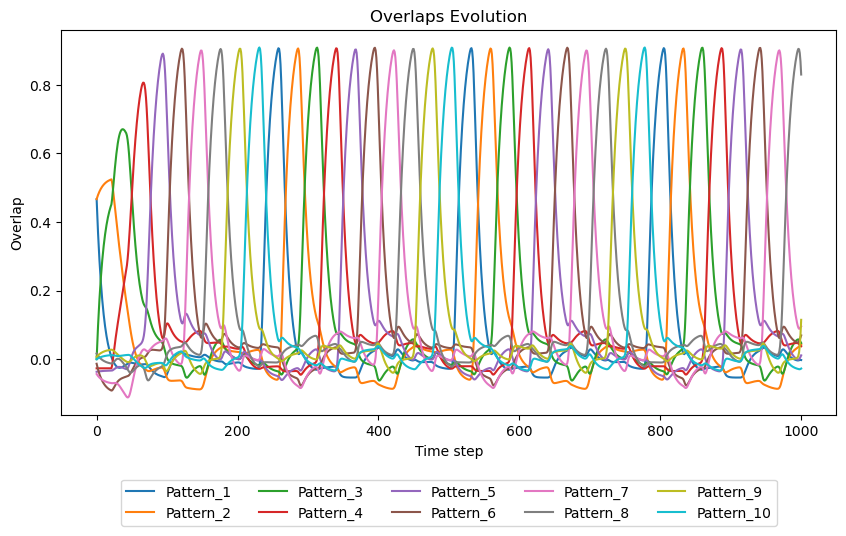

In [ ]:

#? build one 10-pattern cyclic network
P_exp, N_exp = 10, 600
patterns = generate_patterns(P_exp, N_exp)


patsa, Xa, Ma =  simulation_continuous(tau_delay = 10.0, control_cycle=False, verbose= True, T=500, exp=(True, 2), P=P_exp, N=N_exp)


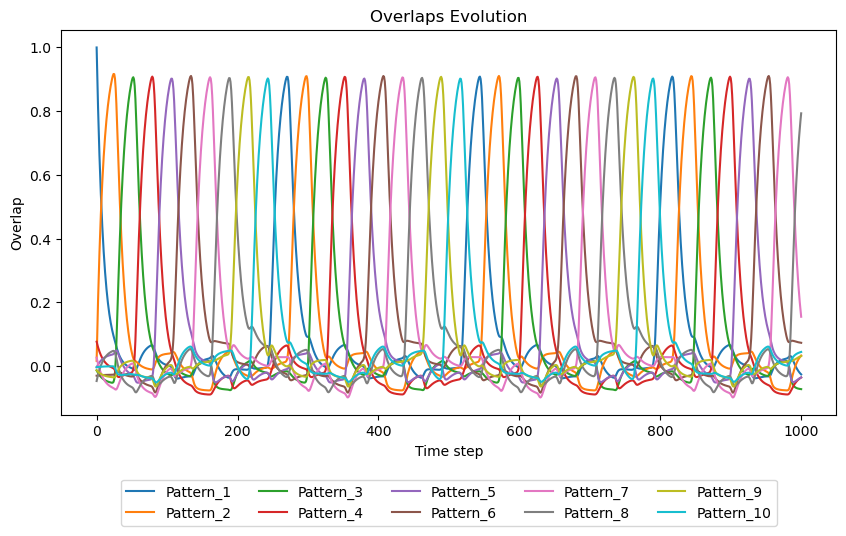

In [257]:
patsb, Xb, Mb=  simulation_continuous(tau_delay = 10.0, control_cycle=False, verbose= True, T=500, exp=(True, 1), P=P_exp, N=N_exp)


1
2
3
4
5
6


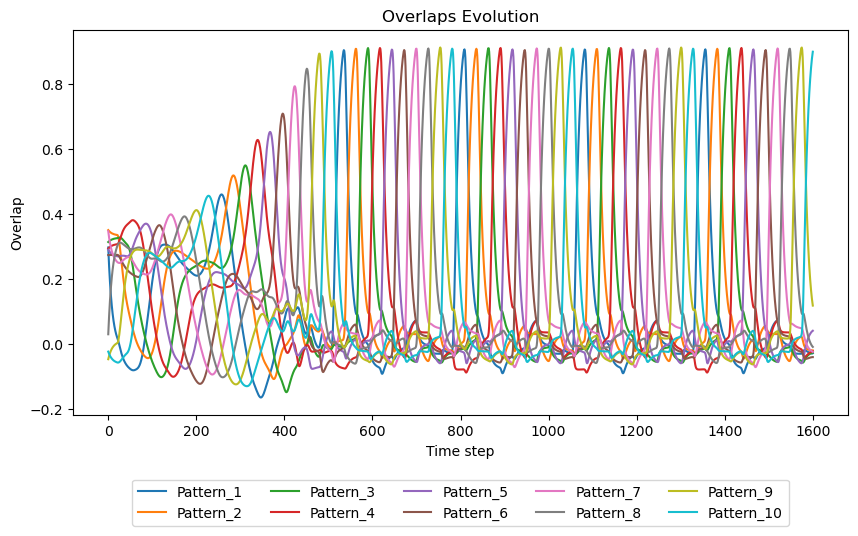

In [259]:
patsb, Xb, Mb=  simulation_continuous(tau_delay = 10.0, control_cycle=False, verbose= True, T=800, exp=(True, 7), P=P_exp, N=N_exp)


<span style="color:blue">

***For the case of Three cycles of different length simultaneously***


(Still the question of wether we can do it in the continuous or the dicrete paradigm)

<span style="color:blue">
Again in this case, the existence of such comparable phenomenon should provide constant overlaps. The dynamic mixtures we expect are more like orbit that includes patterns from two or more stored cycles in a reproducible order.

Design of the experiment : 
- Create 3 cycles of different number of patterns (e.g. 3, 4, 5)
- Construct their weight matrices, and *add them* (with or without normalizing)
- Choose an initialization ; either a combination of the three first patterns, or a random pick
- Run the update
- Record the overlaps

# **Ex 3. Dimensionality analysis**

Goal : find components (like patterns) along which most varies over time, with the idea being that axes along which the state varies are relevant for the functioning of the network.

<span style="color:blue">

## **3.1**




In [ ]:

def compute_covariance (states) :
    '''
    Args :
    states (, N) : historic of states from the evolution of the system


    Returns :
    eigenvalues (, )
    '''
    C = np.cov(states)

    vals, vects, = np.linalg.eigh(C)
    #* The column eigenvectors[:, i] is the normalized eigenvector corresponding to the eigenvalue eigenvalues[i]

    eigenvalues = np.flip(vals)
    eigenvectors = np.flip(vects, axis = 1)

    return eigenvalues, eigenvectors 



Early stopping | Cycle retreived


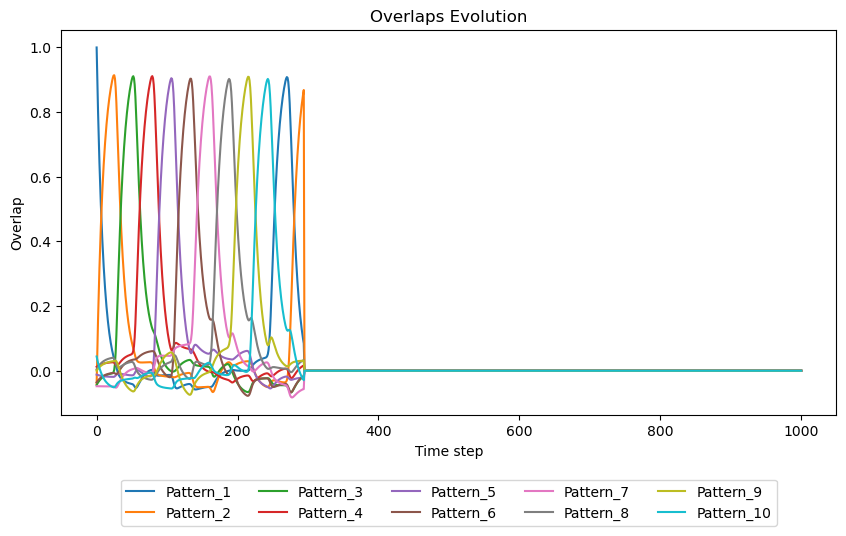

In [10]:

#! Debug to test the 3.1 function
pats, X, M, retr =  simulation_continuous(N = 500, P = 10, tau_delay = 10.0, control_cycle=True, verbose= True, T=500)

In [24]:
values, vectors = compute_covariance(X)
print(values.shape)
#print(vectors.nonzero())
#print(vectors.nonzero()[0].shape)
#print(vectors.shape)
#print(X)

(1001,)


In [ ]:
def compute_loadings (states, components):
    #? Faire une manip pour assurer la correspondance ou pas ?
    eigenval, eigenvect = compute_covariance(states)
    #!l_k = np.dot (vect_k, x) -> les faire en matrices ? ; donne les loadings
    loading = 0 
    for i in range(components) :
        loading += np

    


    return 